In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize

In [2]:
assets = ["TSLA", "BND", "SPY", "GLD", "EFA", "DBC"]  # Modify as needed
start_date = "2015-01-01"
end_date = "2025-07-31"

# Download data
try:
    df = yf.download(assets, start=start_date, end=end_date)
    print("Data downloaded successfully.")
except Exception as e:
    print(f"Error downloading data: {e}")
    raise

# Forward-fill missing values and drop remaining NaNs
df = df.ffill().dropna()
print("Data Shape:", df.shape)
print(df.head())


C:\Users\hp\AppData\Local\Temp\ipykernel_8816\3254721738.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(assets, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed

Data downloaded successfully.
Data Shape: (2659, 30)
Price           Close                                                \
Ticker            BND        DBC        EFA         GLD         SPY   
Date                                                                  
2015-01-02  61.378372  15.931045  44.573956  114.080002  171.568054   
2015-01-05  61.556618  15.703834  43.521786  115.800003  168.469620   
2015-01-06  61.734818  15.555271  43.028801  117.120003  166.882782   
2015-01-07  61.771973  15.459144  43.507069  116.430000  168.962326   
2015-01-08  61.675434  15.520315  44.095695  115.940002  171.960571   

Price                       High                                    ...  \
Ticker           TSLA        BND        DBC        EFA         GLD  ...   
Date                                                                ...   
2015-01-02  14.620667  61.408078  16.062128  44.978638  114.800003  ...   
2015-01-05  14.006000  61.578896  15.861134  43.985329  116.000000  ...   
201

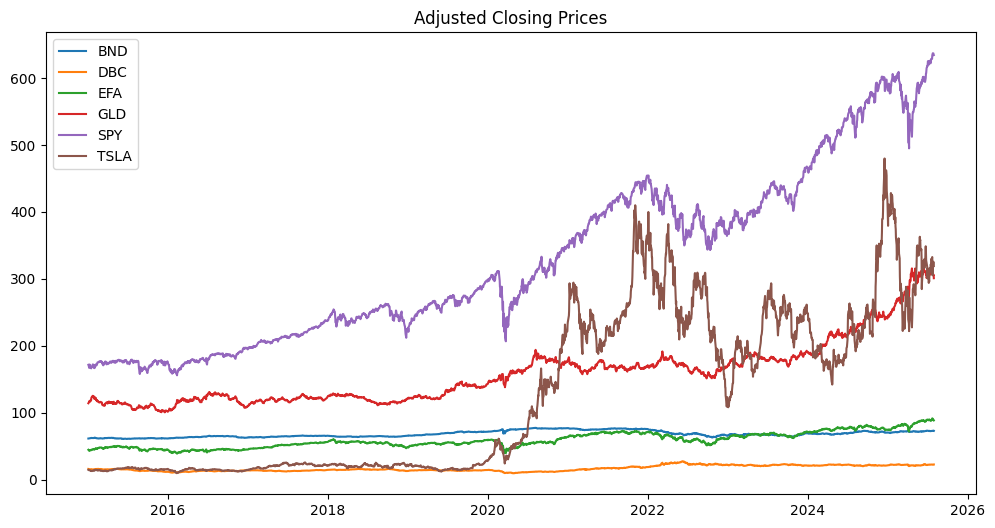

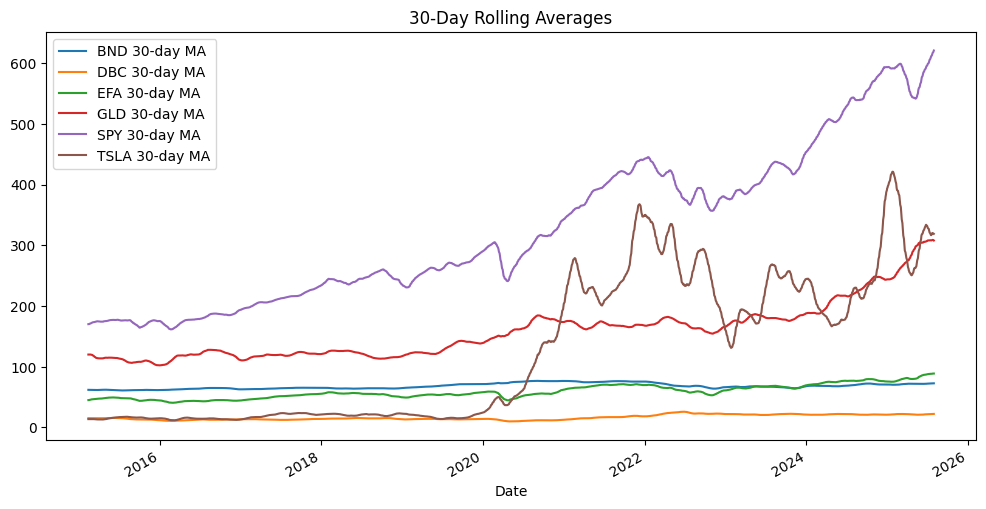

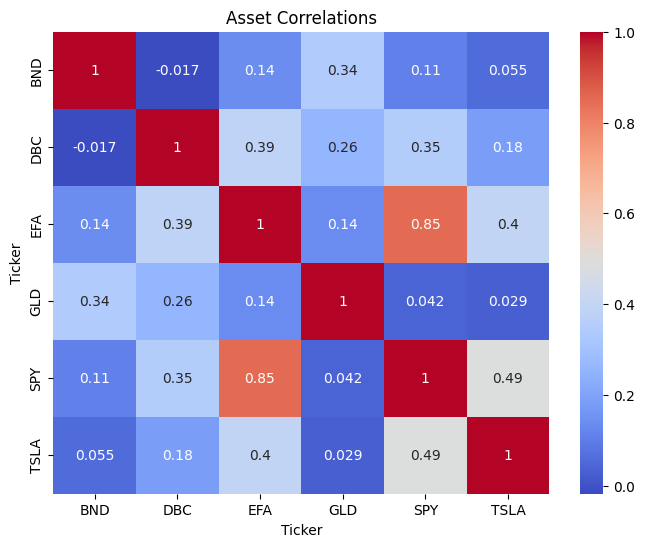

In [3]:
plt.figure(figsize=(12, 6))
for col in df['Close'].columns:
    plt.plot(df.index, df['Close', col], label=col)
plt.title("Adjusted Closing Prices")
plt.legend()
plt.show()

# Rolling averages and volatility
plt.figure(figsize=(12, 6))
for col in df['Close'].columns:
    df['Close', col].rolling(30).mean().plot(label=f"{col} 30-day MA")
plt.title("30-Day Rolling Averages")
plt.legend()
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df['Close'].pct_change().corr(), annot=True, cmap="coolwarm")
plt.title("Asset Correlations")
plt.show()

Forecasting for GLD...


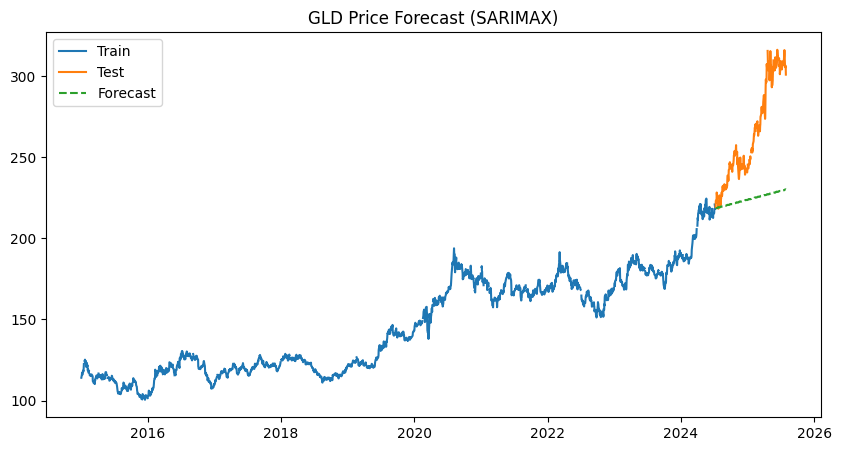

In [4]:
# -----------------------------
# 5. Forecasting Example
# -----------------------------
def forecast_asset(asset, df, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)):
    print(f"Forecasting for {asset}...")
    series = df['Close', asset].asfreq('B')

    # Train-test split
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Fit SARIMAX model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fitted_model = model.fit(disp=False)

    # Forecast
    forecast = fitted_model.forecast(steps=len(test))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(test.index, forecast, label="Forecast", linestyle="--")
    plt.title(f"{asset} Price Forecast (SARIMAX)")
    plt.legend()
    plt.show()

    return forecast

# Example: Forecast for GLD
forecast_gld = forecast_asset("GLD", df)


In [5]:
# -----------------------------
# 6. Portfolio Optimization
# -----------------------------
# Calculate daily returns
returns = df['Close'].pct_change().dropna()

# Mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Objective function: negative Sharpe ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    portfolio_return = np.dot(weights, mean_returns) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Constraints: weights sum to 1, no short-selling
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(assets)))

# Initial guess
init_guess = [1 / len(assets)] * len(assets)

# Optimize
optimized = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized.x
print("Optimized Portfolio Weights:")
for asset, weight in zip(assets, optimized_weights):
    print(f"{asset}: {weight:.2%}")

# Save results
pd.DataFrame({"Asset": assets, "Weight": optimized_weights}).to_csv("optimized_portfolio.csv", index=False)


Optimized Portfolio Weights:
TSLA: 0.00%
BND: 0.00%
SPY: 0.00%
GLD: 55.20%
EFA: 30.51%
DBC: 14.28%


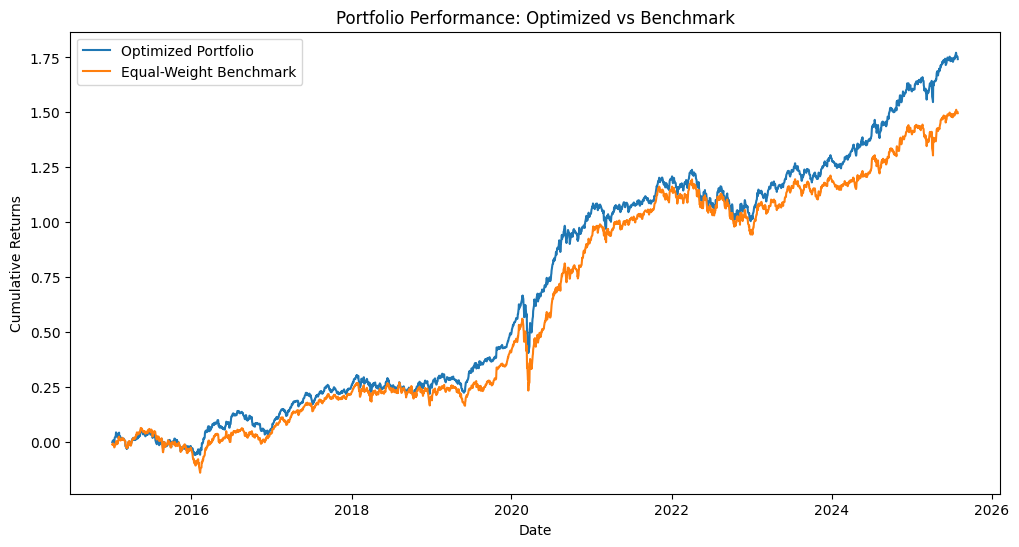

Forecasting for GLD...


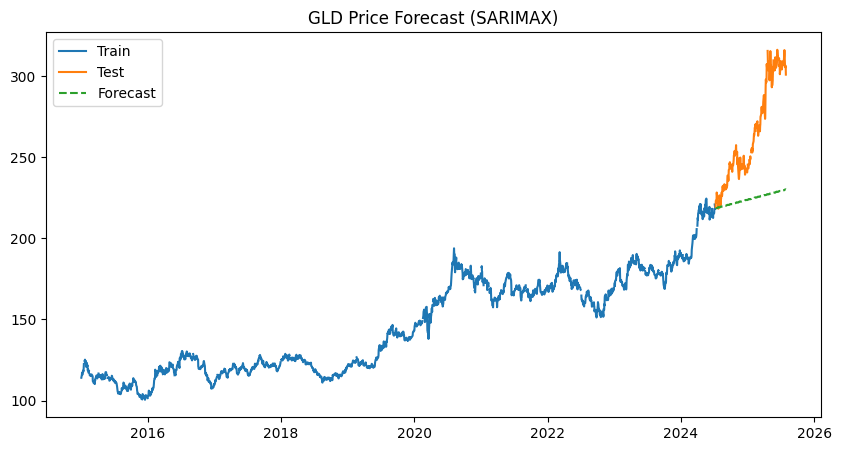

In [11]:
# First, update the forecast_asset function to return all values
def forecast_asset(asset, df, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)):
    print(f"Forecasting for {asset}...")
    series = df['Close', asset].asfreq('B')

    # Train-test split
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Fit SARIMAX model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fitted_model = model.fit(disp=False)

    # Forecast
    forecast = fitted_model.forecast(steps=len(test))

    return train, test, forecast

# Then, update the backtesting section
# -----------------------------
# 7. Backtesting
# -----------------------------
# Simulate portfolio returns
portfolio_returns = (returns @ optimized_weights).cumsum()

# Benchmark: Equal-weighted portfolio
benchmark_weights = [1 / len(assets)] * len(assets)
benchmark_returns = (returns @ benchmark_weights).cumsum()

# Plot benchmark comparison
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.index, portfolio_returns, label='Optimized Portfolio')
plt.plot(benchmark_returns.index, benchmark_returns, label='Equal-Weight Benchmark')
plt.title('Portfolio Performance: Optimized vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Forecast GLD
asset_to_forecast = "GLD"
train, test, forecast = forecast_asset(asset_to_forecast, df)

# Save forecast plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast", linestyle="--")
plt.title(f"{asset_to_forecast} Price Forecast (SARIMAX)")
plt.legend()

# Save the plot with absolute path
plt.savefig(r"d:\GitHub\10acadamy\FinSight-TimeSeries\notebooks\forecast_gld.png")
plt.show()

In [12]:
# 8. Save Outputs

# Save portfolio weights
pd.DataFrame({"Asset": assets, "Weight": optimized_weights}).to_csv("optimized_portfolio.csv", index=False)